In [3]:
import torch

from torchfem import Planar


## A simple cantilever beam in 2D 

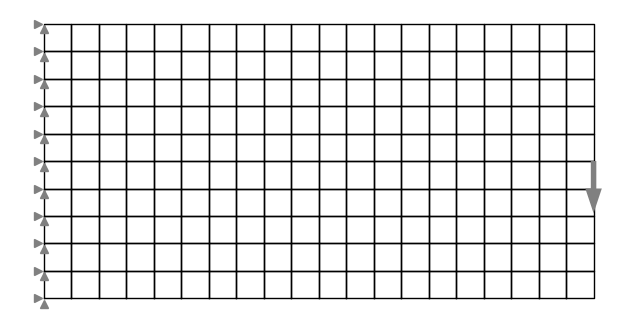

In [4]:
# Dimensions
Nx = 20
Ny = 10
Lx = 2.0
Ly = 1.0

# Material model (plane stress)
E = 1000.0
nu = 0.3
C = (E / ((1.0 + nu) * (1.0 - 2.0 * nu))) * torch.tensor(
    [[1.0 - nu, nu, 0.0], [nu, 1.0 - nu, 0.0], [0.0, 0.0, 0.5 - nu]]
)

# Create nodes
n1 = torch.linspace(0.0, Lx, Nx + 1)
n2 = torch.linspace(0.0, Ly, Ny + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(Ny):
    for i in range(Nx):
        # Quad elements
        n0 = i + j * (Nx + 1)
        elements.append([n0, n0 + 1, n0 + Nx + 2, n0 + Nx + 1])

# Load at tip
forces = torch.zeros_like(nodes)
forces[(int((Ny + 1) / 2) + 1) * (Nx + 1) - 1, 1] = -1.0

# Constrained displacement at left end
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
for i in range(Ny + 1):
    constraints[i * (Nx + 1), :] = True

# Thickness
thickness = 0.1 * torch.ones(len(elements))

cantilever = Planar(nodes, elements, forces, displacements, constraints, thickness, C)
cantilever.plot()


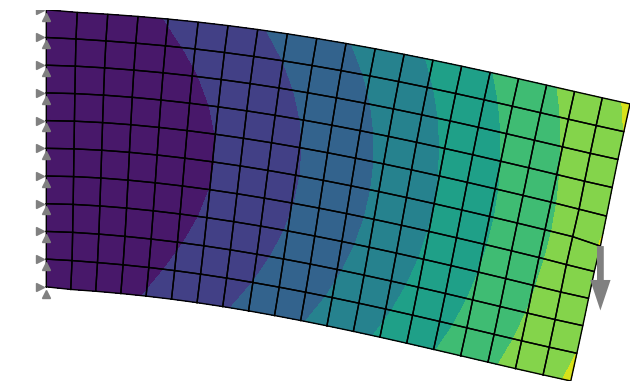

In [5]:
# Solve
u, f = cantilever.solve()
# Plot
cantilever.plot(u, node_property=torch.norm(u, dim=1))